# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random as rand
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

# install package for displaying animation
!pip install JSAnimation
from JSAnimation.IPython_display import display_animation
from IPython.display import display

# render ai gym environment
!pip install gymnasium[accept-rom-license]
!pip install gymnasium[atari]
!pip install gymnasium
import gymnasium as gym

!pip install progressbar
import progressbar as pb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using device: ",device) 

using device:  cpu


In [3]:

[k for k in list(gym.envs.registry.keys()) if "Pong" in k]

['Pong-v0',
 'PongDeterministic-v0',
 'PongNoFrameskip-v0',
 'Pong-v4',
 'PongDeterministic-v4',
 'PongNoFrameskip-v4',
 'Pong-ram-v0',
 'Pong-ramDeterministic-v0',
 'Pong-ramNoFrameskip-v0',
 'Pong-ram-v4',
 'Pong-ramDeterministic-v4',
 'Pong-ramNoFrameskip-v4',
 'ALE/Pong-v5',
 'ALE/Pong-ram-v5']

In [5]:
# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment

env = gym.make('PongDeterministic-v4', full_action_space=False, render_mode='rgb_array')#, render_fps=12)
#env = gym.make('Pong-v4', full_action_space=False, frameskip=1, render_mode='rgb_array', old_step_api=True)#, obs_type='grayscale'

#print(env.metadata['render_fps'])
print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py
RIGHT=4
LEFT=5

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [6]:
env.metadata

{'render_modes': ['human', 'rgb_array'],
 'obs_types': {'grayscale', 'ram', 'rgb'}}

# Utils

In [6]:
def output_volume(in_dims, k, s, p, transpose=False):
    ''' Calculate a convolutional layer's output size params:
        in_dims = input size 
        k = kernel size 
        s = stride (int)
        p = padding (int)
    '''
    if not transpose:
        out_size = (in_dims - k + 2*p)/s + 1 #convolution out
    else:
        out_size = (in_dims - 1)*s + k - 2*p #deconvolution out
    return int(np.floor(out_size))

# preprocess a single frame
# crop image and downsample to 80x80
# stack two frames together as input
def preprocess_single(image, bkg_color = np.array([144, 72, 17])):
    img = np.mean(image[34:-16:2,::2]-bkg_color, axis=-1)/255.
    return img

# convert outputs of parallelEnv to inputs to pytorch neural net
# this is useful for batch processing especially on the GPU
def preprocess_batch(images, bkg_color = np.array([144, 72, 17])):
    list_of_images = np.asarray(images)
    if len(list_of_images.shape) < 5:
        list_of_images = np.expand_dims(list_of_images, 1)
    # subtract bkg and crop
    list_of_images_prepro = np.mean(list_of_images[:,:,34:-16:2,::2]-bkg_color,
                                    axis=-1)/255.
    batch_input = np.swapaxes(list_of_images_prepro,0,1)
    return torch.from_numpy(batch_input).float().to(device)


# function to animate a list of frames
def animate_frames(frames):
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
    display(display_animation(fanim, default_mode='once'))
    
# play a game and display the animation
# nrand = number of random steps before using the policy
def play(env, policy, time=2000, preprocess=None, nrand=5):
    env.reset()

    # start game
    env.step(1)
    
    # perform nrand random steps in the beginning
    for _ in range(nrand):
        frame1, reward1, is_done, is_trunc, info = env.step(np.random.choice([RIGHT,LEFT]))
        frame2, reward2, is_done, is_trunc, info = env.step(0)
        is_done = is_done or is_trunc
    
    anim_frames = []
    
    for _ in range(time):
        
        frame_input = preprocess_batch([frame1, frame2])
        prob = policy(frame_input)
        
        # RIGHT = 4, LEFT = 5
        action = RIGHT if rand.random() < prob else LEFT
        frame1, _, is_done, is_trunc, _ = env.step(action)
        frame2, _, is_done, is_trunc, _ = env.step(0)
        is_done = is_done or is_trunc

        if preprocess is None:
            anim_frames.append(frame1)
        else:
            anim_frames.append(preprocess(frame1))

        if is_done:
            break
    
    env.close()
    
    animate_frames(anim_frames)
    return 


# collect trajectories for a parallelized parallelEnv object
def collect_trajectories(envs, policy, tmax=200, nrand=5):
    
    # number of parallel instances
    n=len(envs.ps)

    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]

    envs.reset()
    
    # start all parallel agents
    envs.step([1]*n)
    
    # perform nrand random steps
    for _ in range(nrand):
        fr1, re1, _, _ = envs.step(np.random.choice([RIGHT, LEFT],n))
        fr2, re2, _, _ = envs.step([0]*n)
    
    for t in range(tmax):

        # prepare the input
        # preprocess_batch properly converts two frames into 
        # shape (n, 2, 80, 80), the proper input for the policy
        # this is required when building CNN with pytorch
        batch_input = preprocess_batch([fr1,fr2])
        
        # probs will only be used as the pi_old
        # no gradient propagation is needed
        # so we move it to the cpu
        probs = policy(batch_input).squeeze().cpu().detach().numpy()
        
        action = np.where(np.random.rand(n) < probs, RIGHT, LEFT)
        probs = np.where(action==RIGHT, probs, 1.0-probs)
        
        
        # advance the game (0=no action)
        # we take one action and skip game forward
        fr1, re1, is_done, _ = envs.step(action)
        fr2, re2, is_done, _ = envs.step([0]*n)

        reward = re1 + re2
        
        # store the result
        state_list.append(batch_input)
        reward_list.append(reward)
        prob_list.append(probs)
        action_list.append(action)
        
        # stop if any of the trajectories is done
        # we want all the lists to be retangular
        if is_done.any():
            break


    # return pi_theta, states, actions, rewards, probability
    return prob_list, state_list, action_list, reward_list

# convert states to probability, passing through the policy
def states_to_prob(policy, states):
    states = torch.stack(states)
    policy_input = states.view(-1,*states.shape[-3:])
    return policy(policy_input).view(states.shape[:-3])

# return sum of log-prob divided by T
# same thing as -policy_loss
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)

    ratio = new_probs/old_probs

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(ratio*rewards + beta*entropy)

    
# clipped surrogate function
# similar as -policy_loss for REINFORCE, but for PPO
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount=0.995,
                      epsilon=0.1, beta=0.01):

    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)
    
    # ratio for clipping
    ratio = new_probs/old_probs

    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)

class Policy_Solution(nn.Module):

    def __init__(self):
        super(Policy_Solution, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



In [ ]:
obs, info = env.reset()
env.step(1)
plt.imshow(preprocess_single(obs), cmap='Greys')

In [1]:
frame = env.render()
plt.imshow(preprocess_single(frame), cmap='Greys')

NameError: name 'env' is not defined

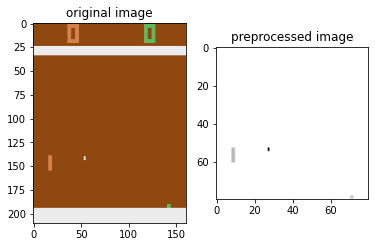

In [23]:

# show what a preprocessed image looks like
obs, info = env.reset()
_, _, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _, _ = env.step(5)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [10]:
output_volume(80,5,3,1)

26

In [9]:
output_volume(26,4,3,1)

9

In [24]:
# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 9x9 here
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=4, stride=3, padding=1)
        self.size=16*9*9
        
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))


In [12]:
# use your own policy!
policy=Policy().to(device)

#import pong_utils
#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

In [13]:
x, y, z, u, w = env.step(1)
print("env.step(1)",x, y, z, u, w)

env.step(1) [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 [[144  72  17]
  [144  72  17]
  [144  72  17]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 [[144  72  17]
  [144  72  17]
  [144  72  17]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 ...

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]] 0.0 False False {'lives': 0, 'episode_frame_number': 88, 'frame_number': 88}


# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [25]:
#import js_examples as jsx
jsx.basic_animation()

C:\ProgramData\Anaconda3\lib\site-packages\JSAnimation\html_writer.py:281: MatplotlibDeprecationWarning: 
The 'clear_temp' parameter of setup() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'clear_temp', they should be passed as keyword, not positionally.
  super(HTMLWriter, self).setup(fig, outfile, dpi,


AttributeError: 'HTMLWriter' object has no attribute '_temp_names'

In [14]:
frame, reward, is_done, is_trunc, info = env.step(1)
print("reward:", reward)

reward: 0.0


In [16]:
import random as rand
play(env, policy, time=100, preprocess=preprocess_single) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

C:\ProgramData\Anaconda3\lib\site-packages\JSAnimation\html_writer.py:281: MatplotlibDeprecationWarning: 
The 'clear_temp' parameter of setup() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. If any parameter follows 'clear_temp', they should be passed as keyword, not positionally.
  super(HTMLWriter, self).setup(fig, outfile, dpi,


AttributeError: 'HTMLWriter' object has no attribute '_temp_names'

In [ ]:
RIGHT=4;LEFT=5
for _ in range(5):
    frame1, reward1, is_done, is_trunc, info = env.step(np.random.choice([RIGHT,LEFT]))
    frame2, reward2, is_done, is_trunc, info = env.step(0)
    is_done = is_done or is_trunc
    if is_done: break

In [ ]:
seed=12345
state, _ = env.reset(seed=seed)
img = plt.imshow(env.render())    
for j in range(100):
    action = agent.act(state)
    state, reward, done, dun, _ = env.step(action)
    done = done or dun
    img.set_data(env.render()) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done:
        break 
#env.close()

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

In [ ]:
# taken from openai/baseline
# with minor edits
# see https://github.com/openai/baselines/baselines/common/vec_env/subproc_vec_env.py
# 
# from parallelEnv.py

from multiprocessing import Process, Pipe
from abc import ABC, abstractmethod

class CloudpickleWrapper(object):
    """
    Uses cloudpickle to serialize contents (otherwise multiprocessing tries to use pickle)
    """

    def __init__(self, x):
        self.x = x

    def __getstate__(self):
        import cloudpickle
        return cloudpickle.dumps(self.x)

    def __setstate__(self, ob):
        import pickle
        self.x = pickle.loads(ob)

class VecEnv(ABC):
    """
    An abstract asynchronous, vectorized environment.
    """

    def __init__(self, num_envs, observation_space, action_space):
        self.num_envs = num_envs
        self.observation_space = observation_space
        self.action_space = action_space

    @abstractmethod
    def reset(self):
        """
        Reset all the environments and return an array of
        observations, or a dict of observation arrays.
        If step_async is still doing work, that work will
        be cancelled and step_wait() should not be called
        until step_async() is invoked again.
        """
        pass

    @abstractmethod
    def step_async(self, actions):
        """
        Tell all the environments to start taking a step
        with the given actions.
        Call step_wait() to get the results of the step.
        You should not call this if a step_async run is
        already pending.
        """
        pass

    @abstractmethod
    def step_wait(self):
        """
        Wait for the step taken with step_async().
        Returns (obs, rews, dones, infos):
         - obs: an array of observations, or a dict of
                arrays of observations.
         - rews: an array of rewards
         - dones: an array of "episode done" booleans
         - infos: a sequence of info objects
        """
        pass

    @abstractmethod
    def close(self):
        """
        Clean up the environments' resources.
        """
        pass

    def step(self, actions):
        """
        Step the environments synchronously.
        This is available for backwards compatibility.
        """
        self.step_async(actions)
        return self.step_wait()

    def render(self, mode='human'):
        #logger.warn('Render not defined for %s' % self)
        pass
        
    @property
    def unwrapped(self):
        if isinstance(self, VecEnvWrapper):
            return self.venv.unwrapped
        else:
            return self

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close()
    env = env_fn_wrapper.x
    while True:
        cmd, data = remote.recv()
        if cmd == 'step':
            ob, reward, done, trunc, info = env.step(data)
            done = done or trunc
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        else:
            raise NotImplementedError

class parallelEnv(VecEnv):
    def __init__(self, env_name='PongDeterministic-v4',
                 n=4, seed=None,
                 spaces=None):
 
        env_fns = [ gym.make('PongDeterministic-v4', full_action_space=False, render_mode='rgb_array') for _ in range(n) ] #gym.make(env_name)

        if seed is not None:
            for i,e in enumerate(env_fns):
                e.seed(i+seed)
        
        """
        envs: list of gym environments to run in subprocesses
        adopted from openai baseline
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, CloudpickleWrapper(env_fn)))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes:
            remote.close()

        self.remotes[0].send(('get_spaces', None))
        observation_space, action_space = self.remotes[0].recv()
        VecEnv.__init__(self, len(env_fns), observation_space, action_space)

    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action))
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
        self.closed = True


In [ ]:
envs = parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = collect_trajectories(envs, policy, tmax=100)

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [ ]:
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    actions = torch.tensor(actions, dtype=torch.int8, device=device)

    # convert states to policy (or probability)
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)

    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(beta*entropy)

Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [ ]:
#from parallelEnv import parallelEnv
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 100
# episode = 800

# widget bar to display progress
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .01
tmax = 320

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    # L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    

In [ ]:
# play game after training!
play(env, policy, time=20) 

In [ ]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
torch.save(policy, 'PPO.policy')

# load your policy if needed
# policy = torch.load('REINFORCE_OG.policy')

# try and test out the solution!
# policy = torch.load('PPO_OG.policy')